In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
import datetime

sns.set_style('darkgrid')
pd.options.display.max_rows = None

In [9]:
transactions = pd.read_csv('../../../data/transactions_train_sample.csv',dtype={"article_id": "str"})
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

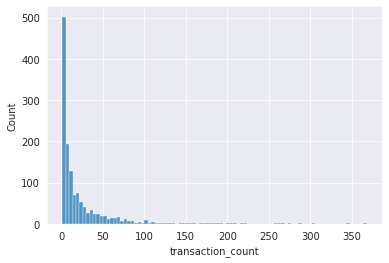

In [10]:
tmp = transactions.groupby('customer_id').article_id.count().reset_index()
tmp.columns = ['customer_id','transaction_count']
sns.histplot(data=tmp,x='transaction_count')

### Map customer_id and article_id to incremental intergers

In [11]:
ALL_USERS = transactions.customer_id.unique().tolist()
ALL_ITEMS = transactions.article_id.unique().tolist()

user_to_customer_map = {u:c for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}
customer_to_user_map = {c:u for u,c in zip(range(len(ALL_USERS)),ALL_USERS)}

item_to_article_map = {i:a for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}
article_to_item_map = {a:i for i,a in zip(range(len(ALL_ITEMS)),ALL_ITEMS)}

transactions['user_id'] = transactions['customer_id'].map(customer_to_user_map)
transactions['item_id'] = transactions['article_id'].map(article_to_item_map)

In [12]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
0,2018-09-20,1a674938eb6b4f9b3ef35eda901f7c8a319f2666b18241...,0493995001,0.020915,2,0,0
1,2018-09-20,1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,0669361001,0.042356,1,1,1
2,2018-09-20,1b291588ef8570d77e354d045dc8041d9235f2437c3d1f...,0669361001,0.042356,1,1,1
3,2018-09-20,1dc5a502ddc5c507ddebc319d570e72e27aa3b0cf24ebd...,0661095001,0.059305,1,2,2
4,2018-09-20,3ea749dbef28880a274d2b57172786a846a3da1d5893a3...,0657415005,0.025407,1,3,3


### Build Model

**Configuration parameters**

Since UUCF is very computationally expensive, we only apply on a small subset of users.

We will reduce data base on 2 fronts:
- Keep only the most recent history from `START_DATE`
- Keep only the user with at least `MINIMUM_PURCHASES`

In [25]:
N_SIMILAR_USERS = 10

MINIMUM_PURCHASES = 3

START_DATE = '2020-08-21' # last month

DROP_PURCHASED_ITEMS = False

DROP_USER_FROM_HIS_NEIGHBORHOOD = True

TEST_RUN = False

TEST_SIZE = 1000

In [66]:
def flatten(l):
    """ Flatten a list of lists"""
    return [item for sublist in l for item in sublist]

In [67]:
def compare_vectors(v1, v2):
    """Compare lists of purchased product for two given users
    v1 stands for the "vector representation for user 1", which is a list of the purchases of u1
    
    Returns:
        A value between 0 and 1 (similarity)
    """
    intersection = len(set(v1) & set(v2))
    denominator = np.sqrt(len(v1) * len(v2))
    return intersection / denominator

In [68]:
def get_similar_users(u, v, dfh):
    """
    Get the N_SIMILAR_USERS most similar users to the given one with their similarity score
    Arguments:
        u: the user_id, 
        v:  the "vector" representation of the user (list of item_id)
        dfh : the "history of transaccions" dataframe
        
    Returns:
        tuple of lists ([similar user_id], [similarity scores])
    """
    similar_users = dfh.apply(lambda v_other: compare_vectors(v, v_other)).sort_values(ascending=False).head(N_SIMILAR_USERS + 1)
    
    if DROP_USER_FROM_HIS_NEIGHBORHOOD:
        similar_users = similar_users[similar_users.index != u]
        
    return similar_users.index.tolist(), similar_users.tolist()

In [69]:
def get_items(u, v, dfh):
    """ Get the recommend items for a given users
    
    It will:
        1) Get similar users for the given user
        2) Obtain all the items those users purchased
        3) Rank them using the similarity scores of the user that purchased them
        4) Return the 12 best ranked
    
    Arguments:
        u: the user_id, 
        v:  the "vector" representation of the user (list of item_id)
        dfh : the "history of transaccions" dataframe
        
    Returns:
        list of item_id of lenght at most 6
    """
    global i, n
    
    users, scores = get_similar_users(u, v, dfh)
    df_nn = pd.DataFrame({'user': users, 'score': scores})
    df_nn['items'] = df_nn.apply(lambda row: dfh.loc[row.user], axis=1)
    df_nn['weighted_items'] = df_nn.apply(lambda row: [(item, row.score) for item in row['items']], axis=1)

    recs = pd.DataFrame(flatten(df_nn['weighted_items'].tolist()), columns=['item', 'score']).groupby('item')['score'].sum().sort_values(ascending=False)
    if DROP_PURCHASED_ITEMS:
        recs = recs[~recs.index.isin(v)]
    # Keep the first 12 and get the item_ids
    i +=1
    if i % 200 == 0:
        pid = mp.current_process().pid
        print(f"[PID {pid:>2d}] Finished {i:3d} / {n:5d} - {i/n*100:3.0f}%")
    return recs.head(6).index.tolist()

In [70]:
def get_items_chunk(user_ids: np.array, dfh: pd.DataFrame):
    """ Call get_item for a list of user_ids
    
    Arguments:
        user_ids: list of user_id, 
        dfh: the "history of transaccions" dataframe
        
    Returns:
        pd.Series with index user_id and list of item_id (recommendations) as value
    """
    global i, n
    i = 0
    
    n = len(user_ids)
    pid = mp.current_process().pid
    print(f"[PID {pid:>2d}] Started working with {n:5d} users")
    
    df_user_vectors = pd.DataFrame(dfh.loc[user_ids]).reset_index()
    df_user_vectors['recs'] = df_user_vectors.apply(lambda row: get_items(row.user_id, row.item_id, dfh), axis=1)
    return df_user_vectors.set_index('user_id')['recs']

In [71]:
def get_recommendations(users: list, dfh: pd.DataFrame):
    """
    Obtained recommendation for the users using transaccion dfh in a parallelized manner
    
    Call get_items_chunk in a "smart" multiprocessing fashion
    
    Arguments:
        users: list of user_id
        dfh: the "history of transaccions" dataframe
    
    Returns:
        pd.DataFrame with index user_id and list of item_id (recommendations) as value
    
    """
    time_start = time.time()
    
    # Split into approximately evenly sized chunks
    # We will send just one batch to each CPU 
    user_chunks = np.array_split(users, mp.cpu_count())
    
    f = partial(get_items_chunk, dfh=dfh)
    with Pool(mp.cpu_count()) as p:
        res = p.map(f, user_chunks)
    
    df_rec = pd.DataFrame(pd.concat(res))

    elapsed = (time.time() - time_start) / 60
    print(f"Finished get_recommendations({len(users)}). It took {elapsed:5.2f} mins")
    return df_rec

In [72]:
def uucf(df, start_date=START_DATE):
    """ Entry point for the UUCF model. 
    
    Receive the original transactions_train.csv and a start_date and gets UUCF recommendations
    
    The model will not cover the full list of users, but just a subset of them.
    
    It will provide recommendations for users with at least MINIMUM_PURCHASES after start_date.
    It might return less than 12 recs per user.
    
    An ad-hoc function for filling these gaps should be used downstream.
    (See fill functionality right below)
    
    
    Arguments:
        df: The raw dataframe from transactions_train.csv
        start_date: a date
        
    Returns:
        a submission-like pd.DataFrame with columns [customer_id, prediction]
        'prediction' is a list and not a string though
    
    """
    df_small = df[df['t_dat'] > start_date]
    print(f"Kept data from {start_date} on. Total rows: {len(df_small)}")
    
    # H stands for "Transaction history"
    # dfh is a series of user_id => list of item_id (the list of purchases in order)
    dfh = df_small.groupby("user_id")['item_id'].apply(lambda items: list(set(items)))
    dfh = dfh[dfh.str.len() >= MINIMUM_PURCHASES]
    if TEST_RUN:
        print("WARNING: TEST_RUN is True. It will be a toy execution.")
        dfh = dfh.head(TEST_SIZE)
    
    users = dfh.index.tolist()
    n_users = len(users)
    print(f"Total users in the time frame with at least {MINIMUM_PURCHASES}: {n_users}")
    
    df_rec = get_recommendations(users, dfh)
    df_rec['customer_id'] = df_rec.index.map(user_to_customer_map)
    df_rec['prediction'] = df_rec['recs'].map(lambda l: [item_to_article_map[i] for i in l])
    
    # Submission ready dataframe
    df_rec.reset_index(drop=True)[['customer_id', 'prediction']]
    return df_rec 

### Prediction


In [21]:
import time
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

In [73]:
df_recs = uucf(transactions)

Kept data from 2020-08-21 on. Total rows: 1244
Total users in the time frame with at least 3: 143
[PID 441] Started working with    72 users
[PID 442] Started working with    71 users
Finished get_recommendations(143). It took  0.02 mins


In [74]:
df_recs.head()

,recs,customer_id,prediction
user_id,,,
6,"[3556, 16656, 13988, 16425, 16510, 16412]",85aaa388d059e619adbb89de4baa175309cd67116fdb56...,"[0715624001, 0683001019, 0841960004, 090454500..."
12,"[2792, 16549, 16663, 16662, 16661, 16628]",c6d3f10175cd49348a5839d1ec301d1e8855955333fc7d...,"[0523490002, 0936610001, 0878800003, 091772000..."
13,"[16328, 14427, 16714, 16713, 16377, 16922]",fe433bc26cb1c5e86601ceab67402de280d8281cc8fcb2...,"[0896152002, 0811500002, 0918522001, 090616900..."
17,"[16490, 16372, 8477, 16410, 16493, 16492]",226834f119ea849fb34402f34cb1a973820523cf2e522f...,"[0556560009, 0736923011, 0519930001, 085466300..."
18,"[16572, 15689, 16463, 16566, 16567, 16568]",4510e9021ef9d554c69bd699603cbd79447232a286c305...,"[0850792002, 0851010008, 0898694001, 090718800..."


In [75]:
df_recs = df_recs.drop(['recs'], axis=1)

In [76]:
df_recs.prediction = df_recs.prediction.apply(lambda x: ' '.join(x))

In [77]:
df_recs.head()

,customer_id,prediction
user_id,,
6,85aaa388d059e619adbb89de4baa175309cd67116fdb56...,0715624001 0683001019 0841960004 0904545002 09...
12,c6d3f10175cd49348a5839d1ec301d1e8855955333fc7d...,0523490002 0936610001 0878800003 0917720001 08...
13,fe433bc26cb1c5e86601ceab67402de280d8281cc8fcb2...,0896152002 0811500002 0918522001 0906169002 08...
17,226834f119ea849fb34402f34cb1a973820523cf2e522f...,0556560009 0736923011 0519930001 0854663002 08...
18,4510e9021ef9d554c69bd699603cbd79447232a286c305...,0850792002 0851010008 0898694001 0907188001 07...


In [78]:
df_recs.to_csv('uucf.csv',index=False)

### Visulize Prediction

In [3]:
df_recs = pd.read_csv('uucf.csv')

In [42]:
index = 30

cus_id = df_recs.loc[index,'customer_id']
pred = df_recs.loc[index,'prediction'].split(' ')
last_mon_purchase = transactions.loc[
    (transactions.customer_id == cus_id) & (transactions.t_dat > START_DATE),
    'article_id'].unique()

print('cus_id:',cus_id)
print('pred:', pred)
print('last_m_purchase:', last_mon_purchase)

cus_id: 5d8d457e8d3a6d98feae4782d8c835ad589f42a339588fcb01c703624da093c4
pred: ['0783346001', '0918525001', '0783346018', '0887457002', '0871477005', '0783346023']
last_m_purchase: ['0301656026' '0783346021' '0584298036' '0783346001' '0581588002'
 '0867470002']


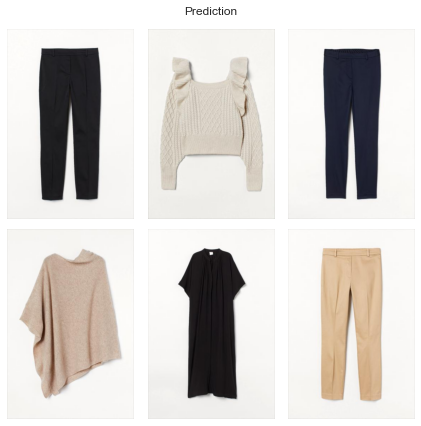

In [43]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(6,6))
axes = axes.flatten()
for im_id,ax in zip(pred,axes):
    ax.axis('off')
    im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)

fig.suptitle('Prediction')
fig.tight_layout()
plt.show()

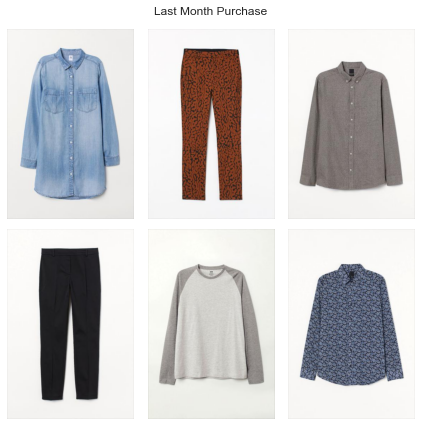

In [44]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(6,6))
axes = axes.flatten()
for im_id,ax in zip(last_mon_purchase,axes):
    ax.axis('off')
    im = plt.imread(f'../../../data/images/{im_id[:3]}/{im_id}.jpg')
    ax.imshow(im)

fig.suptitle('Last Month Purchase')
fig.tight_layout()
plt.show()